### MSDS 453 - Final Project
Summer 2024
Akhilesh Nair

Import Necessary Libraries

In [28]:
import tensorflow as tf
import pandas as pd
import numpy
import sklearn
import transformers
import torch
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, AdamW 

Load in google dataset: GeoEmotions

In [2]:
dataset1 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv')
dataset2 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv')
dataset3 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv')

frame = [dataset1, dataset2, dataset3]
full_data = pd.concat(frame)

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 71224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

Cleaning the data

In [4]:
# function to convert text to lowercase while also removing special char, nums and punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

full_data['cleaned_text'] = full_data['text'].apply(clean_text)

In [5]:
full_data.head(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,that game hurt
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,sexuality shouldn t be a grouping category it...
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,you do right if you don t care then fuck em
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,man i love reddit
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,name was nowhere near them he was by the falcon


Now, let's drop all the useless columns, like the author, time created, rater approval, link_id, parent_id, rater_id etc... I will keep the subreddit for reference though.

In [6]:
full_data.drop(['id', 'author', 'link_id', 'parent_id', 'created_utc', 'rater_id'], axis=1, inplace=True)

In [7]:
full_data.head(5)

,text,subreddit,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text
0,That game hurt.,nrl,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,that game hurt
1,>sexuality shouldn’t be a grouping category I...,unpopularopinion,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sexuality shouldn t be a grouping category it...
2,"You do right, if you don't care then fuck 'em!",confessions,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,you do right if you don t care then fuck em
3,Man I love reddit.,facepalm,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,man i love reddit
4,"[NAME] was nowhere near them, he was by the Fa...",starwarsspeculation,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,name was nowhere near them he was by the falcon


As the data is already encoded via one hot encoding, we can move on to splitting the test and train set.

In [ ]:
emotion_columns = [col for col in full_data.columns[3:31]]

In [ ]:
X = full_data['cleaned_text']
y = full_data[emotion_columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Now, let us tokenize the data.

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)


train_encodings = {key: torch.tensor(val) for key, val in train_encodings.items()}
test_encodings = {key: torch.tensor(val) for key, val in test_encodings.items()}

train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

In [ ]:
# Create a TensorDataset directly
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Now that our data is good and ready, let's start training 

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])

# This will move us to the gpu --- THIS DOES NOT MOVE US TO THE GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
# from tensorflow.keras import layers, regularizers

# k.clear_session()
# inputs = tf.keras.Input(shape=(None,), dtype="int64")
# embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
# x = layers.LSTM(
#     32,
#     kernel_regularizer=regularizers.l2(0.01)
# )(embedded)
# x = layers.Dropout(0.5)(x)  #
# outputs = layers.Dense(4, activation="softmax")(x)
# model = tf.keras.Model(inputs, outputs)
# model.compile(optimizer="rmsprop",
#               loss="SparseCategoricalCrossentropy",
#               metrics=["accuracy"])
# model.summary()

# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint("LSTM_L2_Dropout.keras", save_best_only=True),
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
# ]
# history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
# model = keras.models.load_model("LSTM_L2_Dropout.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
import torch.nn as nn

loss_fn = nn.BCEWithLogitsLoss()

with tf.device('/device:GPU:1'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(torch.cuda.is_available())  # This should return True if GPU is accessible
    print(torch.version.cuda)  # This should return the CUDA version PyTorch is using
    print('in the while loop')
    for epoch in range(3):
        print('enter loop 1')
        model.train()
        total_loss = 0
        print('exit loop 1')
        for batch in train_loader:
            print('enter loop 2')
            # Move batch to device
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Calculate loss
            loss = loss_fn(logits, labels.float())  # Make sure labels are in the correct format (float)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print('exit loop 2')
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
print('out of the while loop')

For some reason, I couldn't switch the processing device for the tensor stuff to the GPU. The fitting time was running upwards of 5 hours when I decided to stop it. I think it would have gone for many 100+ hours. I have way too many data points, will have to take a subset to train the model. Another option is to do a smaller scale version of BERT, known as distillBERT.

Step 1 is to cut half off the data points. So let's do that. I found this code that allows me to take a percentage of my data, so we will be doing that instead of the whole data set. I also kinda want to shuffle the rows just in case theres some bias with the data.

In [10]:
reduced_data = full_data.sample(frac=0.4, random_state=42)

print(f"Original data size: {full_data.shape[0]}")
print(f"Reduced data size: {reduced_data.shape[0]}")

Original data size: 211225
Reduced data size: 84490


In [11]:
full_data.head(5)

,text,subreddit,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text
0,That game hurt.,nrl,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,that game hurt
1,>sexuality shouldn’t be a grouping category I...,unpopularopinion,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,sexuality shouldn t be a grouping category it...
2,"You do right, if you don't care then fuck 'em!",confessions,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,you do right if you don t care then fuck em
3,Man I love reddit.,facepalm,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,man i love reddit
4,"[NAME] was nowhere near them, he was by the Fa...",starwarsspeculation,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,name was nowhere near them he was by the falcon


In [12]:
reduced_data.head(5)

,text,subreddit,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text
65844,Literally everywhere. There's nothing especial...,texas,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,literally everywhere there s nothing especiall...
54522,"[NAME] and [NAME] may be stronger, but [NAME] ...",freefolk,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,name and name may be stronger but name just g...
48835,Ik I’m crying rn,Paladins,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,ik i m crying rn
14996,"He was cut yesterday, unfortunately",detroitlions,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,he was cut yesterday unfortunately
23016,"Nice, I saw them during the Demo and was prett...",socialism,False,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,nice i saw them during the demo and was pretty...


Seems like taking a subset automatically randomizes the data. Nice! But despite this, it seems to be taking from the bottom rather than the top.. Let's see what happens regardless Now let's redo the steps we had done up to begin the training process

In [13]:
emotion_columns = [col for col in reduced_data.columns[3:31]]
X = reduced_data['cleaned_text']
y = reduced_data[emotion_columns]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

train_encodings = {key: torch.tensor(val) for key, val in train_encodings.items()}
test_encodings = {key: torch.tensor(val) for key, val in test_encodings.items()}

train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=y_train.shape[1])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\akhil\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\akhil\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\akhil\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\akhil\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Okay, so now that we've done this, I'm going to use chatGPT to use EarlyStopping in the code.

In [18]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [19]:
early_stopping = EarlyStopping(patience=3, min_delta=0.01)

In [20]:
for epoch in range(10):  # Set to 10 epochs, but early stopping may halt earlier
    model.train()
    total_loss = 0

    for batch in train_loader:
        # Move batch to device
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = loss_fn(logits, labels.float())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels.float())
            val_loss += loss.item()

    val_loss /= len(test_loader)
    total_loss /= len(train_loader)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check early stopping criteria
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1, Training Loss: 0.1499, Validation Loss: 0.1218
Epoch 2, Training Loss: 0.1187, Validation Loss: 0.1172
Epoch 3, Training Loss: 0.1121, Validation Loss: 0.1163
Epoch 4, Training Loss: 0.1069, Validation Loss: 0.1172
Early stopping triggered


In [23]:
save_path = 'C:/Users/akhil/OneDrive/Documents/School/Summer 2024/MSDS 453/distillBert_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to C:/Users/akhil/OneDrive/Documents/School/Summer 2024/MSDS 453/distillBert_model.pth


Wow - 1640 minutes to train this. I was worried it would crash at some point and I would have to redo it. Regardless, we've finally got it. Let's move on and get some results.

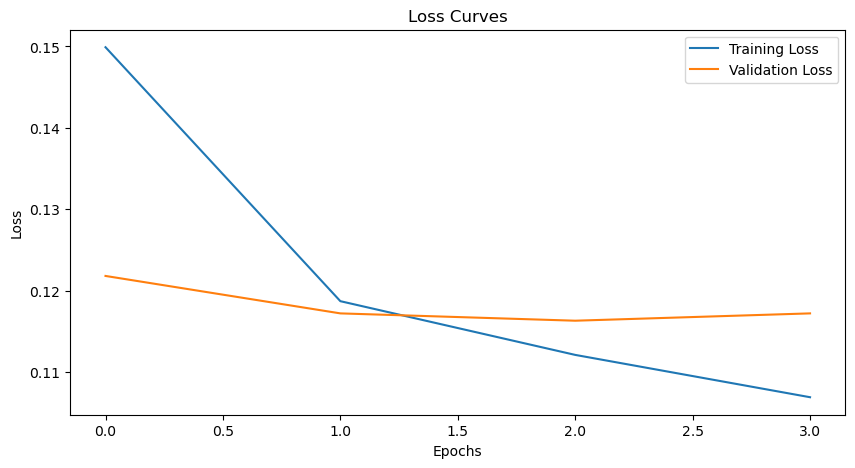

In [29]:
train_losses = [0.1499, 0.1187, 0.1121, 0.1069]
val_losses = [0.1218, 0.1172, 0.1163, 0.1172]

# Plotting the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        preds = (preds > 0.5).astype(int) 

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

for i in range(y_train.shape[1]):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for Label {i}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_columns))

accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')